#### Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
#from lightgbm import LGBMRegressor  # sckit에서 lightgbm을 wrapping한 것
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import Utility as Util

########
buildingID, buildingName = 'B0008', '용학초등학교'
file_path = '/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/data_colec_h_202509091411_B0019.csv'
#########
df_buildID = pd.read_csv(file_path)
df_buildID['colec_dt'] = pd.to_datetime(df_buildID['colec_dt']).dt.floor('min')  # 분 이하는 제거
print(f"timestamp(first~last): {df_buildID['colec_dt'].iloc[0]} ~ {df_buildID['colec_dt'].iloc[-1]}")
print(f"timestamp(min~max):    {df_buildID['colec_dt'].min()} ~ {df_buildID['colec_dt'].max()}")

start_date, end_date = pd.to_datetime('2025-03-24 17:45:00'), pd.to_datetime('2025-09-09 14:05:00')
df_raw_all = df_buildID[(df_buildID['colec_dt'] >= start_date) & (df_buildID['colec_dt'] <= end_date)]

timestamp(first~last): 2025-03-24 17:45:00 ~ 2025-09-09 14:05:00
timestamp(min~max):    2025-03-24 17:45:00 ~ 2025-09-09 14:05:00


#### devID, tagCD extraction

In [2]:
devID, device_name = 2001, '학교MAIN'

Util.print_tagCD(df_raw_all, devID)
tag_dict = {30001: '현재 출력'}
#tag_dict = {40004: '전체누적사용량_차'}  # {30001: '현재 출력'} 대신에 전체누적사용량_차를 사용
tag_dict = {key: f"{value}@{device_name}" for key, value in tag_dict.items()}
# dictionary를 이용해 각 태그 데이터를 선택
tags = {key: Util.select_devID_tagCD(df_raw_all, devID, tagCD=key) for key in tag_dict.keys()}
#tags[40004] = Util.calc_tagCD_diff(tags[40004])  # '전체누적사용량_차'

# 그래프를 그리기 위해 필요한 데이터를 리스트로 변환
tag_data = [tags[key] for key in tag_dict.keys()]
tag_names = [tag_dict[key] for key in tag_dict.keys()]
Util.plot_dfL_devID_tagCD(tag_data, tag_names, device_name, createFig=False)

tagCD list:  [ 30001  50001  40004 202202]


#### Step A. Feature Engineering, lightGBM Modeling
  - LightGBM은 tree-based 모델로 scaling을 특별히 요구하지 않음
  - Prediction model 일 때는, 과거 데이터 정보(X)로만 현재 데이터(y)를 Regression 할 수 있도록 함
  - 일반적인 Regression model 일 때는, 타 데이터의 현재 데이터(X)를 사용해도 됨
  - 참고로, LSTM은 (t-k, ..., t-1) ---> t 에서 별도의 feature engineering을 수행하지 않음 
  - train_test_split() 에서, prediction model에서는 shuffle=False, regression model에서는 shuffle=True

timestamp: 2025-04-01 13:22:00, 2025-09-09 14:05:00
nan_counts max= 677, missing_ratio= 0.3
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	validation's rmse: 23.9934
Experiment A: rmse_a= 23.99 with 61 features


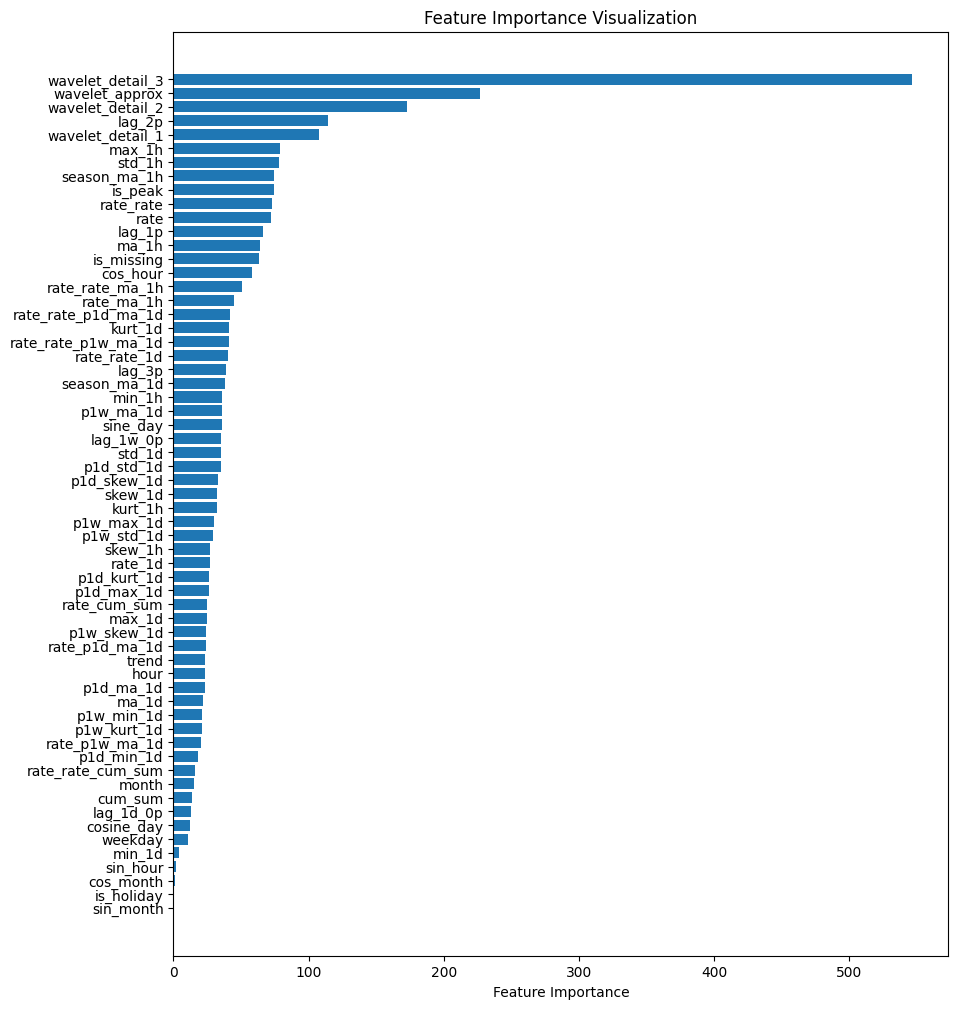

In [3]:
%load_ext autoreload
%autoreload 2

import MainPower_DataProcessing as DP

df_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
#df_raw = df_raw.iloc[int(len(df_raw)/2-1500):-1].copy()
print(f"timestamp: {df_raw.index[0]}, {df_raw.index[-1]}")
#df_interpol = Util.resample_time_index_interpolate_NaN_df(df_raw, '15min', 'linear')
#Util.plot_interpolated_data(df_raw, df_interpol, device_name, createFig=True)
#Util.plot_data(df_raw, plotType='simple', title=None, W=10, H=5)

X_df, y_df, nan_counts_df, missing_ratio = DP.preprocess(df_raw, points=4, freqInterval='15min')
print(f"nan_counts max= {nan_counts_df.max()}, missing_ratio= {missing_ratio}")

# 학습 및 테스트 데이터 분할
# 시계열 데이터는 시간 순으로 되어 있어야 하고, shuffle=False로 순방향 데이터검증 보장
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42, shuffle=False)
#train_size = int(len(X) * 0.8)
#X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
#y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 하이퍼파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 50,
    'verbose': -1
}

# 모델 학습
model_a = lgb.train(params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=30)])

##################
# 예측 수행
y_pred_a = model_a.predict(X_test, num_iteration=model_a.best_iteration)

# RMSE 출력
rmse_a = root_mean_squared_error(y_test, y_pred_a)
print(f'Experiment A: {rmse_a= :.2f} with {X_df.shape[1]} features')

# 예측 결과 시각화
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw['value'], mode='lines', name='Actual Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Cleaned Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_a, mode='lines', name='Predicted Value'))

# Update layout
fig.update_layout(title='Actual vs Predicted Values',
                  xaxis_title='Date',
                  yaxis_title='Values',
                  legend_title='Legend',
                  legend=dict(x=0, y=1, xanchor='left', yanchor='top', orientation='h')
                  )
fig.show()

# Feature Importance Visualization
# 모델의 특성 중요도 추출
feature_importances = model_a.feature_importance()
feature_names = X_df.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 12))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance Visualization')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

#### (Option) 보조 Step. Features Reduction (Experiment B)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	validation's rmse: 23.7554
Experiment A: rmse_a= 23.99 with 61 features
Experiment B: rmse_b= 23.76 with 32 features


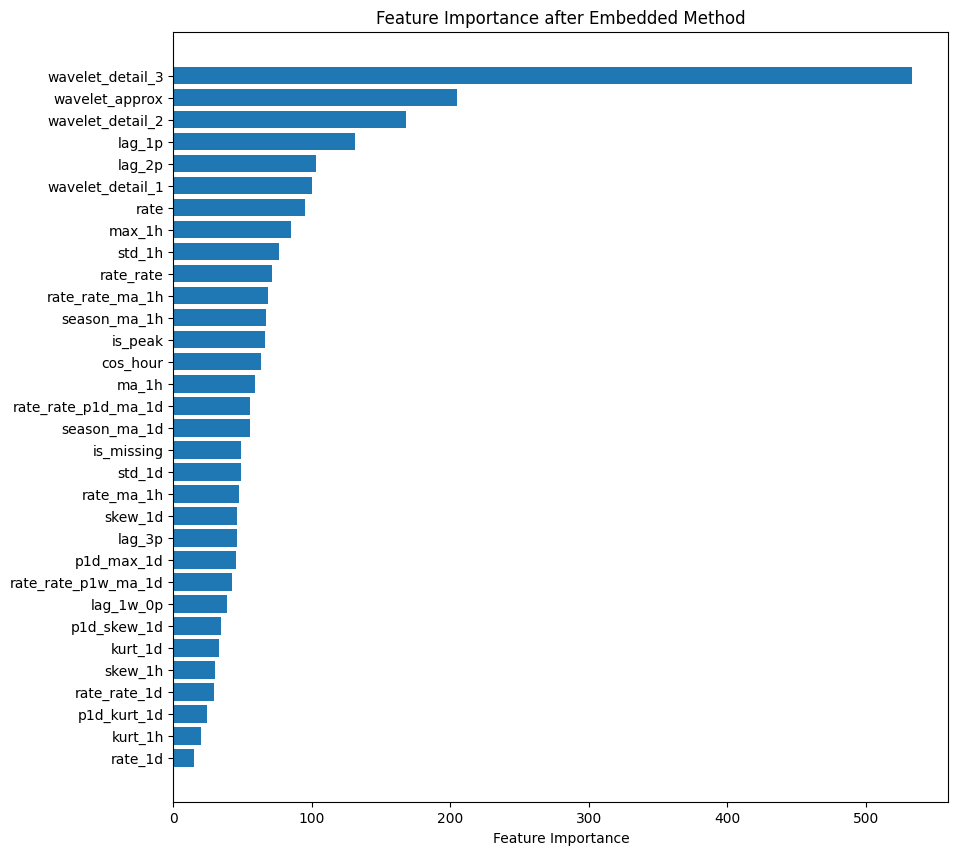

['is_missing' 'cos_hour' 'lag_1p' 'lag_2p' 'lag_3p' 'lag_1w_0p' 'rate'
 'rate_rate' 'rate_1d' 'rate_rate_1d' 'ma_1h' 'max_1h' 'std_1h' 'skew_1h'
 'kurt_1h' 'std_1d' 'skew_1d' 'kurt_1d' 'p1d_max_1d' 'p1d_skew_1d'
 'p1d_kurt_1d' 'rate_ma_1h' 'rate_rate_ma_1h' 'rate_rate_p1d_ma_1d'
 'rate_rate_p1w_ma_1d' 'season_ma_1h' 'season_ma_1d' 'wavelet_approx'
 'wavelet_detail_1' 'wavelet_detail_2' 'wavelet_detail_3' 'is_peak']


In [8]:
# Experiment B. Feature Reduction을 적용 후 (Embedded Method with lightgbm 적용)

from sklearn.feature_selection import SelectFromModel

# 기존 모델과 동일한 하이퍼파라미터 설정
lgb_estimator = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    learning_rate=0.1,
    num_leaves=50,
    verbose=-1
)

# SelectFromModel을 사용하여 중요하지 않은 특성 제거
selector = SelectFromModel(estimator=lgb_estimator, threshold='median')

# 훈련 데이터에 대해 fit
selector.fit(X_train, y_train)

# 선택된 특성 이름 추출
selected_features = X_train.columns[selector.get_support()]

# 선택된 특성으로 데이터셋 변환
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# LightGBM 데이터 세트 생성 (선택된 특성 사용)
train_data_selected = lgb.Dataset(X_train_selected, label=y_train)
valid_data_selected = lgb.Dataset(X_test_selected, label=y_test, reference=train_data_selected)

# 모델 재학습 (선택된 특성 사용)
model_b = lgb.train(params,
                    train_data_selected,
                    valid_sets=[valid_data_selected],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=30)])

# 예측 수행
y_pred_b = model_b.predict(X_test_selected, num_iteration=model_b.best_iteration)

# RMSE 출력
rmse_b = root_mean_squared_error(y_test, y_pred_b)
print(f'Experiment A: {rmse_a= :.2f} with {X_df.shape[1]} features')
print(f'Experiment B: {rmse_b= :.2f} with {X_train_selected.shape[1]} features')

# 선택된 특성 중요도 시각화
feature_importances_b = model_b.feature_importance()
importance_df_b = pd.DataFrame({'feature': selected_features, 'importance': feature_importances_b})
importance_df_b = importance_df_b.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
plt.barh(importance_df_b['feature'], importance_df_b['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance after Embedded Method')
plt.gca().invert_yaxis()
plt.show()

importance_df_b_sort = importance_df_b.sort_index()
features_b = importance_df_b_sort['feature'].values
#print(f'{importance_df_b= }')
print(f'{features_b}')

#### (Option) 보조 Step. Hyperparameter Optimization (Optuna)

In [ ]:
# optuna를 이용한 하이퍼파라미터 최적화

import os, optuna

# optuna_study.db 삭제 여부
if True:
    file_path_optuna_study_db = r"/home/ymatics/CodingSpace/2024_AI_BEMS/optuna_study.db"
    if os.path.exists(file_path_optuna_study_db):
        os.remove(file_path_optuna_study_db)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, shuffle=False)
#X_train, X_test, y_train, y_test = X_train_selected, X_test_selected, y_train, y_test

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 하이퍼파라미터 설정 및 optuna를 이용한 튜닝
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1
    }
    
    # 모델 학습
    model = lgb.train(params,
                      train_data,
                      valid_sets=[valid_data],
                      num_boost_round=1000,
                      valid_names=['validation'],
                      callbacks=[lgb.early_stopping(stopping_rounds=10)])
    
    # 예측 수행
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # RMSE 계산
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

# 최적화 수행
# Optuna 스터디 생성 (SQLite 스토리지 사용)
STUDY_NAME = "optuna_study"
DB_PATH = "sqlite:///optuna_study.db"  # SQLite 데이터베이스 파일 경로
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=DB_PATH,
    direction='minimize',
    load_if_exists=True  # 기존 스터디가 있으면 불러옴
)
study.optimize(objective, n_trials=10)  # 30
print('Best hyperparameters: ', study.best_params)

# 최적 하이퍼파라미터로 모델 재학습
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'

model_opt = lgb.train(best_params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=30)])

# 예측 수행
y_pred_opt = model_opt.predict(X_test, num_iteration=model_opt.best_iteration)

# RMSE 출력
rmse_opt = root_mean_squared_error(y_test, y_pred_opt)

print('*'*30) 
print(f'Experiment(Optimization): {rmse_opt= :.2f} with {X_train.shape[1]} features')
print(f'{model_opt.params= }')

#### Save the model & Run Inference

In [4]:
buildingID, devID, tagCD = buildingID, devID, list(tag_dict.keys())[0]
file_path_AI_model = f"/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/MainPower_Prediction_LGBM.txt"
model_a.save_model(file_path_AI_model)
#model_opt.save_model(file_path_AI_model)

# 모델 로드
model_infer = lgb.Booster(model_file=file_path_AI_model)

# 예측 수행 (로드된 모델 사용)
y_pred_a = model_infer.predict(X_test)

# 모델 평가
rmse_loaded = root_mean_squared_error(y_test, y_pred_a)
print(f'RMSE (Loaded Model): {rmse_loaded= :.2f}')
print(f'{file_path_AI_model= }')

# RMSE 평가
p_ = 4
rmse_over_time = np.sqrt((y_test - y_pred_a)**2)
daily_rmse = rmse_over_time.resample('1d').mean()
daily_rmse = rmse_over_time.rolling(window=p_ * 24).mean()

# 예측 결과 시각화
fig = go.Figure()

# Add traces for values
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Cleaned Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_a, mode='lines', name='Predicted Value'))

# Update layout with secondary y-axis
fig.update_layout(
    title='Time Series Anomaly Detection with Daily RMSE (Loaded Model)', 
    xaxis_title='Date',
    yaxis_title='Values',
    yaxis=dict(
        range=[-10, 400]
    ),
    legend_title='Legend',
    legend=dict(x=0.5, y=0.9, xanchor='center', yanchor='bottom', orientation='h')
)
fig.show()

RMSE (Loaded Model): rmse_loaded= 23.99
file_path_AI_model= '/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/MainPower_Prediction_LGBM.txt'


#### Main Power Peak Suppression

In [5]:
%load_ext autoreload
%autoreload 2

import MainPower_DataProcessing as DP
import Utility as Util

df_interpol, df_is_missing, nan_counts_df, missing_ratio = DP.preprocess(df_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='zero')
#Util.plot_df_raw_interpololated_data(df_raw, df_interpol, plotType='plotly', title=None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# 특정 기간 데이터에 대해서 일별 최대값과 해당 시간 인덱스를 찾아 통계 처리

start_date, end_date = '2025-09-02', '2025-09-09' # 2024-10-14
df_period = df_interpol[(df_interpol.index >= start_date) & (df_interpol.index <= end_date)].copy()

# 일별 최대값과 해당 시간 인덱스를 찾기
daily_peaks = df_period.resample('D').apply(lambda x: x['value'].idxmax())
daily_peak_values = df_period.resample('D').apply(lambda x: x['value'].max())

# 결과를 DataFrame으로 결합
daily_peak_info = pd.DataFrame({
    'Peak Time': daily_peaks,
    'Peak Value': daily_peak_values
})

# 피크 시간에서 시간과 분을 추출
daily_peak_info['Peak Time'] = daily_peak_info['Peak Time'].dt.strftime('%H:%M')
# 00:00 시의 피크 시간 제외
daily_peak_info = daily_peak_info[daily_peak_info['Peak Time'] != '00:00']

# 피크 시간의 빈도 계산
peak_time_freq = daily_peak_info['Peak Time'].value_counts().sort_index()
# 각 시간대의 최대 피크 값 계산
peak_time_max_values = daily_peak_info.groupby('Peak Time')['Peak Value'].max().astype(int).sort_index()

Util.plot_peak_time_distribution(peak_time_freq, peak_time_max_values, start_date, end_date)
"""2023-01-03 12:30:00에 최대치 521"""

'2023-01-03 12:30:00에 최대치 521'

In [7]:
daily_peak_info

,Peak Time,Peak Value
colec_dt,,
2025-09-02,14:15,186.71
2025-09-03,13:15,142.35
2025-09-04,10:00,190.66
2025-09-05,14:00,148.95
2025-09-06,11:15,303.58
2025-09-07,14:30,229.53
2025-09-08,10:15,175.03
